<table align="left">
    <td>
<a href="https://colab.research.google.com/github/epearcecrump/Fashion-MNIST/blob/main/imageClassification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
    </td>
</table>

# Image Classification in `PyTorch`.

In this notebook, we are going to develop a neural network model for classify images from the Fashion-MNIST dataset.

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
import itertools
from sklearn import metrics

## 1. Load and visualise the data.

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are 10 label classes in total, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [2]:
# Load data
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes
print(f"List of class names: {class_name}")

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

List of class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Display the dimension of the training and test sets.

In [3]:
print(f"The shape of train_image is {train_image.shape}")
print(f"The shape of train_label is {train_label.shape}")
print(f"The shape of test_image is {test_image.shape}")
print(f"The shape of test_label is {test_label.shape}")

The shape of train_image is (60000, 28, 28)
The shape of train_label is (60000,)
The shape of test_image is (10000, 28, 28)
The shape of test_label is (10000,)


### Visualise sample images from the dataset with their respective labels.

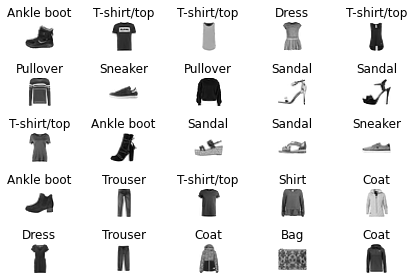

In [4]:
num_rows = 5
num_cols = 5
num_images = num_rows * num_cols
for i in range(num_images):
    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow((train_image[i]), cmap='binary')
    plt.axis("off")
    plt.title(class_name[train_label[i]])
plt.tight_layout()
plt.show()

### Display the number of training samples for each class.

In [5]:
_ , counts = np.unique(train_label, return_counts = True)
dictionary = dict(zip(class_name, counts))
print(f"The number of training samples for each class is {dictionary}.")

The number of training samples for each class is {'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle boot': 6000}.


### Expand the dimensions of train_image and test_image.

In [6]:
train_image = np.expand_dims(train_image, axis=1)
test_image = np.expand_dims(test_image, axis=1)

print(f"The shape of train_image is {train_image.shape}")
print(f"The shape of test_image is {test_image.shape}")

The shape of train_image is (60000, 1, 28, 28)
The shape of test_image is (10000, 1, 28, 28)


## 2. Creating and evaluating a Convolutional Neural Network model.

### Obtain a GPU device for training, otherwise use a CPU.

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using a {device} device for training.")

Using a cuda device for training.


### Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset.

In [8]:
class ConvNN(nn.Module):
    def __init__(self):
        """
        A convolutional neural network whose pipeline is very similar to that of LeNet.
        
        It initially pads the 28x28 input image (of 1 channel) with a padding of 2
        to replicate the C1 output of LeNet (i.e it returns 6 28x28 feature maps).
        
        Note that the softmax activation function is not applied to the final 10 inputs 
        into the final layer because the CrossEntropyLoss() function used later 
        combines nn.LogSoftmax() and nn.NLLLoss() (negative log likelihood loss) in one go,
        that is, the CrossEntropyLoss() function will apply the softmax activation function 
        to these inputs and thus create an output vector of probabilites that will classify
        the input image(s).
        """
        super(ConvNN, self).__init__()
        
        # Note that the input to layer1 will be 1 feature map of size 28x28
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0)
        )
        
        # Use dropout in order to avoid overfitting to the training data.
        self.dropout = nn.Dropout()
        
        self.fc1 = nn.Linear(in_features = 120, out_features = 84)
        self.fc2 = nn.Linear(in_features = 84, out_features = 10)
        
    def forward(self, x):
        """
        Runs an input matrix of features through the Convolutional Neural Network
        and returns a vector of size 10x1 which will be used after the CrossEntropyLoss()
        function is applied (later) to classify each input image.
        """
        out = self.layer1(x)
        out = self.layer2(out)
        # The output will be 120 feature maps of size 1x1, we reshape it to be a 120 dimensional vector ready
        # for input into the nn.Linear layer.
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

### Instantiate a ConvNN and print the model architecture.

In [9]:
convNet = ConvNN().to(device)
print(convNet)

ConvNN(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


### Define the loss function, optimiser and hyper-parameters used for training the model.

In [10]:
# Set the hyperparameters
epochs = 5
classes = 10
batch_size = 100
learning_rate = 0.001

# Loss Function:
loss_function = nn.CrossEntropyLoss()

# Optimiser:
optimiser = optim.Adam(convNet.parameters(), lr = learning_rate)

### Start model training.

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed them into the network model and perform gradient descent.

In [11]:
def print_epoch(epoch):
    print(f"------------------------------------------------------------------")
    print(f"                           Epoch {epoch+1}                        ")
    print(f"------------------------------------------------------------------")


def train(classifier, X, y, batch_size, epochs, optimiser, loss_function, device):
    # Calculate the number of iterations per epoch:
    num_of_iterations = y.shape[0]//batch_size
    
    # Arrays to be used for analysis later.
    loss_list = []
    accuracy_list = []
    
    for epoch in range(epochs):
        # Randomise X and y.
        randomise = np.arange(len(X))
        np.random.shuffle(randomise)
        X_shuffled = X[randomise]
        y_shuffled = y[randomise]
    
        # Print header stating which epoch the training is currently in.
        print_epoch(epoch)
    
        for batch in range(num_of_iterations):
            # Take each cut for the images and labels and turn them into tensors.
            X_cut = X_shuffled[(batch*batch_size):((batch+1)*batch_size)] 
            X_cut = torch.from_numpy(X_cut)
            X_cut = X_cut.type(torch.float32)
            X_cut = X_cut.to(device)

            y_cut = y_shuffled[(batch*batch_size):((batch+1)*batch_size)]
            y_cut = torch.from_numpy(y_cut)
            y_cut = y_cut.to(device)

            # Pass them through the classifier and compute the prediction error.
            outputs = classifier(X_cut)
            loss = loss_function(outputs, y_cut)
            
            # Perform backpropagation
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Calculate the accuracy statistics.
            total = y_cut.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == y_cut).sum().item()
            accuracy = correct / total
            accuracy_list.append(accuracy)

            # Print the Loss and Accuracy at the end of every 100th iteration.
            if (batch + 1) % 100 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%"
                      .format(epoch + 1, epochs, batch + 1, num_of_iterations, loss.item(), accuracy * 100))
                      
    return loss_list, accuracy_list

In [12]:
start = time.time()
loss_list, accuracy_list = train(convNet, train_image, train_label, batch_size, epochs, optimiser, loss_function, device)
end = time.time()

print(f"It took {end - start:.2f} seconds to train the model on the training set.")

------------------------------------------------------------------
                           Epoch 1                        
------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Step [100/600], Loss: 0.6686, Accuracy: 80.00%
Epoch [1/5], Step [200/600], Loss: 0.4035, Accuracy: 86.00%
Epoch [1/5], Step [300/600], Loss: 0.5674, Accuracy: 79.00%
Epoch [1/5], Step [400/600], Loss: 0.6199, Accuracy: 83.00%
Epoch [1/5], Step [500/600], Loss: 0.6055, Accuracy: 84.00%
Epoch [1/5], Step [600/600], Loss: 0.4640, Accuracy: 84.00%
------------------------------------------------------------------
                           Epoch 2                        
------------------------------------------------------------------
Epoch [2/5], Step [100/600], Loss: 0.3581, Accuracy: 86.00%
Epoch [2/5], Step [200/600], Loss: 0.5173, Accuracy: 87.00%
Epoch [2/5], Step [300/600], Loss: 0.4532, Accuracy: 82.00%
Epoch [2/5], Step [400/600], Loss: 0.3435, Accuracy: 89.00%
Epoch [2/5], Step [500/600], Loss: 0.3782, Accuracy: 88.00%
Epoch [2/5], Step [600/600], Loss: 0.4054, Accuracy: 86.00%
------------------------------------------------------------------
                    

### Deploy the trained model on the test set.

In [13]:
start = time.time()
convNet.eval()
with torch.no_grad():
    test_image_tensor = test_image
    test_image_tensor = torch.from_numpy(test_image_tensor)
    test_image_tensor = test_image_tensor.type(torch.float32)
    test_image_tensor = test_image_tensor.to(device)
    
    test_label_tensor = test_label
    test_label_tensor = torch.from_numpy(test_label_tensor)
    test_label_tensor = test_label_tensor.to(device)
    
    outputs = convNet(test_image_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
end = time.time()
print(f"It took {end - start:.2f} seconds to deploy the trained model on the test set.")

It took 0.01 seconds to deploy the trained model on the test set.


### Evaluate the classification accuracy on the test set.

In [14]:
total = test_label_tensor.size(0)
correct = (predicted == test_label_tensor).sum().item()
test_accuracy = correct / total * 100

print(f"The test accuracy of the model on the {total} test images is {test_accuracy:.{2}f}%.")

The test accuracy of the model on the 10000 test images is 86.85%.


### Print out and visualise the confusion matrix.

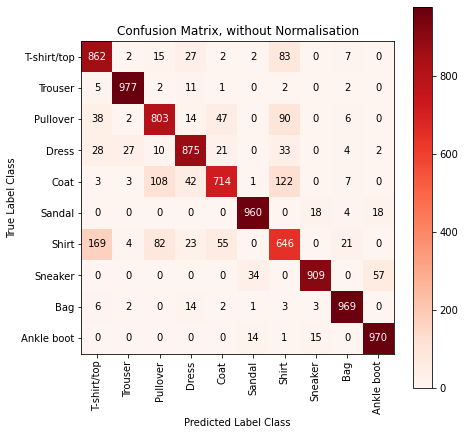

In [15]:
if device == 'cuda':
        # Moves the tensors back to a cpu if it's on a gpu before calculating the confusion matrix.
        test_label_tensor = test_label_tensor.cpu()
        predicted = predicted.cpu()

cm = metrics.confusion_matrix(test_label_tensor, predicted)

plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)
plt.colorbar() 

tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=90)
plt.yticks(tick_marks, class_name)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title("Confusion Matrix, without Normalisation")
plt.xlabel("Predicted Label Class") 
plt.ylabel("True Label Class") 

plt.show()

### Save the model for later use.

In [16]:
torch.save(convNet.state_dict(), "convNet.pth")
print("Saved PyTorch Model State to convNet.pth")

Saved PyTorch Model State to convNet.pth
